# 布尔索引

In [1]:
import jieba
class SearcherScan():
    def __init__(self, title_file):
        with open(title_file, 'r') as f:
            titles = f.read()
        self.title_list = list(set(titles.split()))

    def word_match(self, words, title):
        ifmatch = True
        keyword_ = ' '.join(jieba.cut(words))
        for word in keyword_.split():
            if word != ' ' and word not in title:
                ifmatch = False
        return ifmatch

    def conv_query(self, query):
        query_new_parts = []
        for part in list(jieba.cut(query)):
            if part == '(' or part == ')':
                query_new_parts.append(part)
            elif part in ('and', 'AND', 'or', 'OR', 'NOT', 'not', ' '):
                query_new_parts.append(part.lower())
            else:
                query_new_parts.append(
                    "self.word_match('{}',title)".format(part))
        query_new = ''.join(query_new_parts)
        return query_new

    def highlighter(self, doc, word):
        for part in list(jieba.cut(word)):
            if part not in ('(', ')', 'and', 'AND', 'or', 'OR', 'NOT', 'not', ' '):
                doc = doc.replace(
                    part, '<span style="color:red">{}</span>'.format(part))
        return doc

    def search(self, query):
        query_new = self.conv_query(query)
        print(query_new)
        for title in self.title_list:
            if eval(query_new):
                print(title, query)

query = '苹果 and (芯片 or 高通)'
searcher = SearcherScan('./爬虫-新闻标题.txt')
searcher.search(query)

import jieba


class SearcherIIndex():
    """倒排索引文本搜索实现类

    用倒排索引
    利用Python的集合运算，来实现候选结果集之间交、并运算

    Attributes:
        index: 检索使用的倒排索引
        max_id: 当前索引的文档最大ID
        doc_list: 索引文档原文
    """

    def __init__(self, docs_file):
        """初始化，用文件中的文本行构建倒排索引

        Args:
            docs_file:包含带索引文档(文本)的文件名

        """
        self.index = dict()
        self.max_id = 0
        self.doc_list = []

        with open(docs_file, 'r') as f:
            docs_data = f.read()

        # 对读取文档的每一行进度 调用 add_doc
        for doc in docs_data.split('\n'):
            self.add_doc(doc)

    def add_doc(self, doc):
        """向索引中添加新文档,每加入一篇新的文章（例子中就是新闻标题）

        Args:
            doc:待检索的文档(文本)

        Returns:
            新增文档ID
        """
        self.doc_list.append(doc)

        # 分词之后的 每个单词
        # self.index 倒排索引
        for term in list(jieba.cut(doc)):
            # 构建和更新各Term对应的Posting(集合)
            if term in self.index:
                self.index[term].add(self.max_id)
            else:
                self.index[term] = set([self.max_id])
        self.max_id += 1
        return self.max_id - 1

    def word_match(self, word):
        """从倒排索引中获取包含word的候选文档ID集合

        Args:
            word:待检索的词(短语)

        Returns：
            包含待检索词(短语)的文档ID集合
        """
        result = None
        for term in list(jieba.cut(word)):
            if result is None:
                result = self.index.get(term, set())
            else:
                result = result & self.index.get(term, set())
        if result is None:
            result = set()
        return result

    def conv_query(self, query):
        """将用户的查询转换成用eval可运行、返回结果ID集合的代码段

        Args:
            query:待转换的原始查询字符串

        Returns:
            转换完成可通过eval执行返回ID集合的代码段字符串
        """
        query_new_parts = []
        all_parts = list(jieba.cut(query))
        idx = 0
        cache = ''  # 缓存变量，用于回收分词过程被切开的短语片段
        count_parts = len(all_parts)

        # pdb.set_trace()

        while idx < count_parts:
            if all_parts[idx] == '(' or all_parts[idx] == ')':
                query_new_parts.append(all_parts[idx])
            elif all_parts[idx] == ' ':
                query_new_parts.append(' ')
            elif all_parts[idx] in ('and', 'AND'):
                query_new_parts.append('&')
            elif all_parts[idx] in ('or', 'OR'):
                query_new_parts.append('|')
            elif all_parts[idx] in ('not', 'NOT'):
                query_new_parts.append('-')
            # 被分词切开的短语部分回收至缓存
            elif idx + 1 < count_parts and all_parts[idx + 1] not in (' ', ')'):
                cache += all_parts[idx]
            else:
                query_new_parts.append(
                    "self.word_match('{}')".format(cache + all_parts[idx]))
                cache = ''  # 合并完成清空缓存
            idx += 1
        query_new = ''.join(query_new_parts)
        return query_new

    def highlighter(self, doc, word):
        """用word对doc进行HTML高亮

        Args:
            doc:需要高亮的文档
            word:要进行高亮的关键词(查询)

        Returns:
            返回对关键词(查询)进行高亮的文档
        """
        for part in list(jieba.cut(word)):
            # TODO(CHG):短语高亮需要先分词
            if part not in ('(', ')', 'and', 'AND', 'or', 'OR', 'NOT', 'not', ' '):
                doc = doc.replace(
                    part, '<span style="color:red">{}</span>'.format(part))
        return doc

    def search(self, query):
        """用query进行查询返回结果文档列表

        Args:
            query:用户的(复合)布尔查询字符串

        Returns:
            复合查询要求的(高亮)文档结果列表
        """
        result = []

        query_new = self.conv_query(query)#转化查询
        print(query_new, eval(query_new))
        for did in eval(query_new):
            result.append([self.doc_list[did]])
        return result

searcher = SearcherIIndex('./爬虫-新闻标题.txt')#se
print(searcher.index['孟买'], searcher.index['贫民窟'])#第一篇文章就有孟买和贫民窟两个词

query = '泰山 and (台北 or 高通)'
for doc in searcher.search(query):
    print(doc)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.729 seconds.
Prefix dict has been built successfully.


self.word_match('苹果',title) and (self.word_match('芯片',title) or self.word_match('高通',title))
外媒揭秘苹果A13芯片：比三星华为高通芯片好在哪 苹果 and (芯片 or 高通)
{1, 12} {24, 1, 11, 12}
self.word_match('泰山') & (self.word_match('台北') | self.word_match('高通')) set()


In [6]:
searcher.doc_list[4]

'300多万就能在美国买豪宅 四室三卫一车库还送花'

In [8]:
searcher.index['贫民窟']

{1, 11, 12, 24}

In [9]:
query = '泰山 and (台北 or 高通)'
for doc in searcher.search(query):
    print(doc)

self.word_match('泰山') & (self.word_match('台北') | self.word_match('高通')) set()


In [10]:
searcher.search(query)

self.word_match('泰山') & (self.word_match('台北') | self.word_match('高通')) set()


[]

# 作业problem1

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [14]:
# ... (Data loading and preprocessing remains the same) ...
dataset = pd.read_csv("../../Week01/Week01/dataset.csv", sep="\t", header=None)
texts = dataset[0].tolist()
string_labels = dataset[1].tolist()

label_to_index = {label: i for i, label in enumerate(set(string_labels))}
numerical_labels = [label_to_index[label] for label in string_labels]#string_labels是每个label

char_to_index = {'<pad>': 0}
for text in texts:
    for char in text:
        if char not in char_to_index:
            char_to_index[char] = len(char_to_index)#为词汇表增加新词

index_to_char = {i: char for char, i in char_to_index.items()}#颠倒字典
vocab_size = len(char_to_index)

max_len = 40

In [32]:
text

'下周一视频会议的闹钟帮我开开'

In [36]:
[char_to_index[char] for char in text[:40]]

[38, 227, 28, 59, 60, 92, 1573, 9, 203, 204, 196, 43, 164, 164]

In [40]:
class CharBoWDataset(Dataset):
    def __init__(self, texts, labels, char_to_index, max_len, vocab_size):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.char_to_index = char_to_index
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.bow_vectors = self._create_bow_vectors()

    def _create_bow_vectors(self):
        tokenized_texts = []
        for text in self.texts:
            tokenized = [self.char_to_index.get(char, 0) for char in text[:self.max_len]]#如果这句话里面出现了字符，是词汇表找不到的,就用0来表示
            tokenized += [0] * (self.max_len - len(tokenized))#补足长度
            tokenized_texts.append(tokenized)

        bow_vectors = []#最终返回一个one-hot的编码,整个数据集每一行包括这个字，就是1，不包括就是0
        for text_indices in tokenized_texts:
            bow_vector = torch.zeros(self.vocab_size)
            for index in text_indices:
                if index != 0:
                    bow_vector[index] += 1
            bow_vectors.append(bow_vector)
        return torch.stack(bow_vectors)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.bow_vectors[idx], self.labels[idx]


class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): # 层的个数 和 验证集精度
        # 层初始化
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 手动实现每层的计算
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


char_dataset = CharBoWDataset(texts, numerical_labels, char_to_index, max_len, vocab_size) # 读取单个样本
dataloader = DataLoader(char_dataset, batch_size=32, shuffle=True) # 读取批量数据集 -》 batch数据

hidden_dim = 128
output_dim = len(label_to_index)
model = SimpleClassifier(vocab_size, hidden_dim, output_dim) # 维度和精度有什么关系？
criterion = nn.CrossEntropyLoss() # 损失函数 内部自带激活函数，softmax
optimizer = optim.SGD(model.parameters(), lr=0.01)

# epoch： 将数据集整体迭代训练一次
# batch： 数据集汇总为一批训练一次

num_epochs = 10
for epoch in range(num_epochs): # 12000， batch size 100 -》 batch 个数： 12000 / 100
    model.train()
    running_loss = 0.0
    for idx, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if idx % 50 == 0:
            print(f"Batch 个数 {idx}, 当前Batch Loss: {loss.item()}")


    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")


Batch 个数 0, 当前Batch Loss: 2.4753546714782715
Batch 个数 50, 当前Batch Loss: 2.447343349456787
Batch 个数 100, 当前Batch Loss: 2.4496562480926514
Batch 个数 150, 当前Batch Loss: 2.4516987800598145
Batch 个数 200, 当前Batch Loss: 2.3922643661499023
Batch 个数 250, 当前Batch Loss: 2.3833091259002686
Batch 个数 300, 当前Batch Loss: 2.349109172821045
Batch 个数 350, 当前Batch Loss: 2.296114683151245
Epoch [1/10], Loss: 2.4104
Batch 个数 0, 当前Batch Loss: 2.311138153076172
Batch 个数 50, 当前Batch Loss: 2.2719573974609375
Batch 个数 100, 当前Batch Loss: 2.231539011001587
Batch 个数 150, 当前Batch Loss: 2.2499899864196777
Batch 个数 200, 当前Batch Loss: 2.185230016708374
Batch 个数 250, 当前Batch Loss: 2.227617025375366
Batch 个数 300, 当前Batch Loss: 2.118140935897827
Batch 个数 350, 当前Batch Loss: 2.2090275287628174
Epoch [2/10], Loss: 2.2190
Batch 个数 0, 当前Batch Loss: 2.0872390270233154
Batch 个数 50, 当前Batch Loss: 2.0195562839508057
Batch 个数 100, 当前Batch Loss: 2.0012521743774414
Batch 个数 150, 当前Batch Loss: 1.927669882774353
Batch 个数 200, 当前Batch Lo

In [58]:
class multiSimpleClassifier(nn.Module):
    def __init__(self, depth,input_dim, hidden_dims, output_dim): # 层的个数和每层的个数变动起来
        #depth必须与hidden_dims的长度一致，后者是一个list
        assert depth == len(hidden_dims)
        assert depth > 0
        super(multiSimpleClassifier, self).__init__()
        self.depth = depth
        self.fc_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.relu_layers.append(nn.ReLU())
        last_hidden_dim =  hidden_dims[0]
        for i in range(1,depth):
            self.fc_layers.append(nn.Linear(last_hidden_dim, hidden_dims[i]))
            self.relu_layers.append(nn.ReLU())
            last_hidden_dim = hidden_dims[i]
        self.outputlayer = nn.Linear(last_hidden_dim,output_dim)

    def forward(self, x):
        out = self.fc_layers[0](x)
        for i in range(1,self.depth):
            out = self.fc_layers[i](out)
            out = self.relu_layers[i](out)
        out = self.outputlayer(out)
        return out

In [57]:
model

multiSimpleClassifier(
  (fc_layers): ModuleList(
    (0): Linear(in_features=2823, out_features=128, bias=True)
  )
  (relu_layers): ModuleList(
    (0): ReLU()
  )
  (outputlayer): Linear(in_features=2823, out_features=12, bias=True)
)

In [68]:
model = multiSimpleClassifier(2,vocab_size, [64,64], output_dim) # 维度和精度有什么关系？维度越高最后训练精度越高，但是越高的维度越高，需要训练时长越高
criterion = nn.CrossEntropyLoss() # 损失函数 内部自带激活函数，softmax
optimizer = optim.SGD(model.parameters(), lr=0.01)

# epoch： 将数据集整体迭代训练一次
# batch： 数据集汇总为一批训练一次

num_epochs = 10
for epoch in range(num_epochs): # 12000， batch size 100 -》 batch 个数： 12000 / 100
    model.train()
    running_loss = 0.0
    for idx, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if idx % 50 == 0:
            print(f"Batch 个数 {idx}, 当前Batch Loss: {loss.item()}")


    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")


Batch 个数 0, 当前Batch Loss: 2.511512041091919
Batch 个数 50, 当前Batch Loss: 2.491431474685669
Batch 个数 100, 当前Batch Loss: 2.4739668369293213
Batch 个数 150, 当前Batch Loss: 2.4572062492370605
Batch 个数 200, 当前Batch Loss: 2.4339189529418945
Batch 个数 250, 当前Batch Loss: 2.4144387245178223
Batch 个数 300, 当前Batch Loss: 2.412508726119995
Batch 个数 350, 当前Batch Loss: 2.410680055618286
Epoch [1/10], Loss: 2.4478
Batch 个数 0, 当前Batch Loss: 2.390932083129883
Batch 个数 50, 当前Batch Loss: 2.3885178565979004
Batch 个数 100, 当前Batch Loss: 2.3806509971618652
Batch 个数 150, 当前Batch Loss: 2.358820915222168
Batch 个数 200, 当前Batch Loss: 2.384573459625244
Batch 个数 250, 当前Batch Loss: 2.3625996112823486
Batch 个数 300, 当前Batch Loss: 2.3117034435272217
Batch 个数 350, 当前Batch Loss: 2.3017780780792236
Epoch [2/10], Loss: 2.3563
Batch 个数 0, 当前Batch Loss: 2.297654151916504
Batch 个数 50, 当前Batch Loss: 2.241058588027954
Batch 个数 100, 当前Batch Loss: 2.2604641914367676
Batch 个数 150, 当前Batch Loss: 2.1939074993133545
Batch 个数 200, 当前Batch Lo

In [67]:
#检查模型的效果
def classify_text(text, model, char_to_index, vocab_size, max_len, index_to_label):
    tokenized = [char_to_index.get(char, 0) for char in text[:max_len]]
    tokenized += [0] * (max_len - len(tokenized))

    bow_vector = torch.zeros(vocab_size)
    for index in tokenized:
        if index != 0:
            bow_vector[index] += 1

    bow_vector = bow_vector.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(bow_vector)

    _, predicted_index = torch.max(output, 1)
    predicted_index = predicted_index.item()
    predicted_label = index_to_label[predicted_index]

    return predicted_label


index_to_label = {i: label for label, i in label_to_index.items()}

new_text = "帮我导航到北京"
predicted_class = classify_text(new_text, model, char_to_index, vocab_size, max_len, index_to_label)
print(f"输入 '{new_text}' 预测为: '{predicted_class}'")

new_text_2 = "查询明天北京的天气"
predicted_class_2 = classify_text(new_text_2, model, char_to_index, vocab_size, max_len, index_to_label)
print(f"输入 '{new_text_2}' 预测为: '{predicted_class_2}'")


输入 '帮我导航到北京' 预测为: 'Travel-Query'
输入 '查询明天北京的天气' 预测为: 'Weather-Query'


# 作业problem2

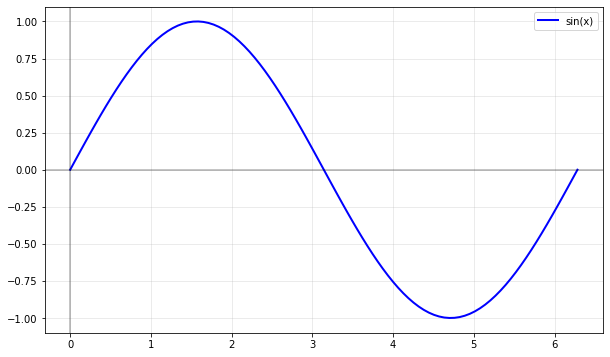

In [86]:
# 创建sin曲线
x = np.linspace(0, 2*np.pi, 100).reshape(-1,1)
y = np.sin(x)

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2, label='sin(x)')
# plt.title('100个点的sin曲线')
# plt.xlabel('x (弧度)')
# plt.ylabel('sin(x)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.show()

数据生成完成。
------------------------------
Epoch [100/20000], Loss: 0.3035
Epoch [200/20000], Loss: 0.2406
Epoch [300/20000], Loss: 0.2086
Epoch [400/20000], Loss: 0.1892
Epoch [500/20000], Loss: 0.1762
Epoch [600/20000], Loss: 0.1669
Epoch [700/20000], Loss: 0.1600
Epoch [800/20000], Loss: 0.1546
Epoch [900/20000], Loss: 0.1503
Epoch [1000/20000], Loss: 0.1468
Epoch [1100/20000], Loss: 0.1440
Epoch [1200/20000], Loss: 0.1415
Epoch [1300/20000], Loss: 0.1394
Epoch [1400/20000], Loss: 0.1376
Epoch [1500/20000], Loss: 0.1360
Epoch [1600/20000], Loss: 0.1345
Epoch [1700/20000], Loss: 0.1332
Epoch [1800/20000], Loss: 0.1320
Epoch [1900/20000], Loss: 0.1308
Epoch [2000/20000], Loss: 0.1297
Epoch [2100/20000], Loss: 0.1286
Epoch [2200/20000], Loss: 0.1275
Epoch [2300/20000], Loss: 0.1265
Epoch [2400/20000], Loss: 0.1254
Epoch [2500/20000], Loss: 0.1243
Epoch [2600/20000], Loss: 0.1231
Epoch [2700/20000], Loss: 0.1218
Epoch [2800/20000], Loss: 0.1205
Epoch [2900/20000], Loss: 0.1191
Epoch [3000/2

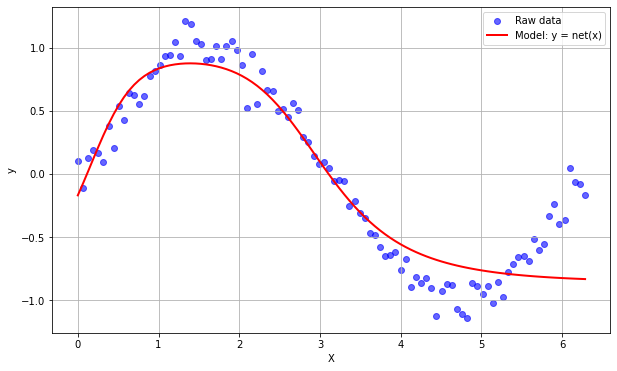

In [103]:
import torch
import numpy as np # cpu 环境（非深度学习中）下的矩阵运算、向量运算
import matplotlib.pyplot as plt

# 1. 生成模拟数据 (与之前相同)
X_numpy =  np.linspace(0, 2*np.pi, 100).reshape(-1,1)
# 形状为 (100, 1) 的二维数组，其中包含 100 个在 [0, 1) 范围内均匀分布的随机浮点数。

y_numpy = np.sin(x)+ np.random.randn(100, 1)*0.1

X = torch.from_numpy(X_numpy).float() # torch 中 所有的计算 通过tensor 计算
y = torch.from_numpy(y_numpy).float()

print("数据生成完成。")
print("---" * 10)

# 2. 直接创建参数张量 a 和 b

# 3. 定义损失函数和优化器
# 损失函数仍然是均方误差 (MSE)。
loss_fn = torch.nn.MSELoss() # 回归任务
# a * x + b 《 - 》  y'
net = nn.Sequential(nn.Linear(1,64),nn.Tanh(),nn.Linear(64,128),nn.Linear(128,1),nn.Tanh())

# 优化器现在直接传入我们手动创建的参数 [a, b]。
# PyTorch 会自动根据这些参数的梯度来更新它们。
optimizer = torch.optim.SGD(net.parameters(), lr=0.001) # 优化器，基于 a b 梯度 自动更新

# 4. 训练模型
num_epochs = 20000
for epoch in range(num_epochs):
    # 前向传播：手动计算 y_pred = a * X + b
    y_pred = net(X)

    # 计算损失
    loss = loss_fn(y_pred, y)

    # 反向传播和优化
    optimizer.zero_grad()  # 清空梯度， torch 梯度 累加
    loss.backward()        # 计算梯度
    optimizer.step()       # 更新参数

    # 每100个 epoch 打印一次损失
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. 打印最终学到的参数
print("\n训练完成！")
print("---" * 10)

# 6. 绘制结果
# 使用最终学到的参数 a 和 b 来计算拟合直线的 y 值
with torch.no_grad():
    y_predicted =  net(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_numpy, y_numpy, label='Raw data', color='blue', alpha=0.6)
plt.plot(X_numpy, y_predicted, label=f'Model: y = net(x)', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()
